# Damage-plasticity 2D interface model
This notebook is a work in progress on an abstract and general implementation of time integration algorithm for general damage-plasticity modes. It serves for the development of a package that can be configured by specifying the ingredients of thermodynamically based model

 - Vector of state variables $\boldsymbol{\mathcal{E}}$
 - Vector of thermodynamic streses $\boldsymbol{\mathcal{S}}$
 - Helmholtz free energy $\psi(\boldsymbol{\mathcal{E}})$
 - Threshold on thermodynamical forces  $f(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$ / Yield condition
 - Flow potential $\varphi(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$

as symbolic equations using the sympy package. The time-stepping algorithm gets generated automatically within the thermodynamically framework. The derived  evolution equations and return-mapping to the yield surface is performed using Newton scheme.  

In [1]:
import sympy as sp
sp.init_printing()
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

**Code generation** The derivation is adopted for the purpose of code generation both in Python and C utilizing the `codegen` package provided in `sympy`. The expressions that are part of the time stepping algorithm are transformed to an executable code directly at the place where they are derived. At the end of the notebook the C code can be exported to external files and applied in external tools. 

In [2]:
# This code is needed to lambdify expressions named with latex symbols
# it removes the backslashes and curly braces upon before code generation.
from sympy.utilities.codegen import codegen
import re
def _print_Symbol(self, expr):
    CodePrinter = sp.printing.codeprinter.CodePrinter
    name = super(CodePrinter, self)._print_Symbol(expr)
    return re.sub(r'[\{^}]','_',re.sub(r'[\\\{\}]', '', name))
sp.printing.codeprinter.CodePrinter._print_Symbol = _print_Symbol

def ccode(cfun_name, sp_expr, cfile):
    '''Generate c function cfun_name for expr and directive name cfile 
    '''
    return codegen((cfun_name, sp_expr), 'C89', cfile + '_' + cfun_name)

## TODO
 - The current implementation uses the threshold function linearized along $\lambda$ to represent the consistency condition. As the next step include the fully linearized set of evolution equations and threshold functions. This might be important for SLIDE 3.x, 2D and 3D problems (von Mises, Drucker-Prager). In the current one-dimensional problem it probably has no effect - this feature will be included in SLIDE-core notebook which should be able to generate all the other problems by configuring the thermodynamic inputs symbolically.  
 - Put the derived get_methods into a class and let the predictor-corrector implementation just access them. With this, the iteration scheme becomes completely generic. Any kind of model can be implemented then using the thermodynamic framework.

&nbsp;<font color='blue'>
**Naming conventions:**
 - Variables with trailing underscore (e.g. `f_`, or `Sig_`) denote `sympy` expressions. 
 - Variables denoting `sympy` symbols (e.g. `Sig` have no underscore at the end and have an the name which is close to the mathematical symbol
 - Mathematical symbols defined as string in `sp.symbols(r'\tau^{\pi}')` use `latex` syntax to introduce Greek symbols, super and subindexes. This makes the pretty printing of expression possible.
 - In an implemented algorithm at the end of the notebook, the Python variables containing the numerical values of the material parameters $E_b$, $\tau_\mathrm{Y}$, etc. are denoted with a leading underscore `_E_b` and `_tau_Y` to avoid name collisions within the notebook
</font>

## Material parameters

In [3]:
E_b = sp.Symbol('E_b', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True, nonnegative=True)
K = sp.Symbol('K', real=True)
S = sp.Symbol('S', real=True)
r = sp.Symbol('r', real=True)
c = sp.Symbol('c', real=True)
bartau = sp.Symbol(r'\bar{\tau}', real=True, nonnegative=True)

In [4]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [5]:
sp_vars = (E_b, gamma, K, S, r, c, bartau)

## State variables

In [6]:
s_x, s_y = sp.symbols('s_x, s_y', real=True)
omega = sp.Symbol('omega', real=True, nonnegative=True)
omega.is_nonnegative
s_pi_x, s_pi_y = sp.symbols(r's^{\pi}_x, s^{\pi}_y', real=True)
alpha_x, alpha_y = sp.symbols('alpha_x, alpha_y', real=True)
z = sp.Symbol('z', real=True)

In [7]:
s = sp.Array([s_x,s_y])
s_pi = sp.Array([s_pi_x, s_pi_y])
alpha = sp.Array([alpha_x, alpha_y])

In [8]:
n_D = sp.Symbol(r'n_D', integer=True,)
eps = sp.MatrixSymbol(r'\varepsilon', n_D, n_D)
eps_pi = sp.MatrixSymbol(r'\varepsilon^{\pi}', n_D, n_D)
eps - eps_pi

In [9]:
Eps = sp.Matrix([s_pi_x, s_pi_y, z, alpha_x, alpha_y, omega])
Eps.T

[s_x__{\pi}  s_y__{\pi}  z  αₓ  α_y  ω]

## Helmholtz free energy

The starting point in the thermodynamical representation of a process is a potential function of time dependent state variables. To describe the evolution of the state correctly describing the energy dissipation of the system the gradient of the potential function with respect to the state variables provides the generalized forces. The forces are constrained to characterize specific material properties, e.g. strength, hardening.

In [10]:
rho_psi_ = sp.Rational(1,2)* ( 
    (1-omega)*E_b*(s_x-s_pi_x)**2 + 
    (1-omega)*E_b*(s_y-s_pi_y)**2 + 
    K * z**2 + 
    gamma * alpha_x**2 +
    gamma * alpha_y**2
)
rho_psi_

In [11]:
(1-omega)*E_b* sp.tensorcontraction(sp.tensorproduct( (s - s_pi),(s - s_pi) ), (0,1) )

## Thermodynamic forces

In [12]:
tau_x, tau_y = sp.symbols('tau_x, tau_y', real=True)
tau_pi_x, tau_pi_y = sp.symbols(r'tau_pi_x, tau_pi_y', real=True)
X_x, X_y = sp.symbols('X_x, X_y', real=True)
Z = sp.Symbol('Z', real=True, nonnegative=True)
Y = sp.Symbol('Y', real=True)

In [13]:
Sig = sp.Matrix([tau_pi_x, tau_pi_y, Z, X_x, X_y, Y])
Sig.T

[τₚᵢ ₓ  τ_π_y  Z  Xₓ  X_y  Y]

The introduce the thermodynamic forces we have to differentiate Hemholtz free energy
with respect to the kinematic state variables
\begin{align}
\frac{\partial \rho \psi }{\partial \boldsymbol{\mathcal{E}}}
\end{align}

In [21]:
d_rho_psi_ = sp.Matrix([rho_psi_.diff(eps) for eps in Eps])
d_rho_psi_

⎡         E_b⋅(1 - ω)⋅(2⋅s_x__{\pi} - 2⋅sₓ)          ⎤
⎢         ─────────────────────────────────          ⎥
⎢                         2                          ⎥
⎢                                                    ⎥
⎢         E_b⋅(1 - ω)⋅(2⋅s_y__{\pi} - 2⋅s_y)         ⎥
⎢         ──────────────────────────────────         ⎥
⎢                         2                          ⎥
⎢                                                    ⎥
⎢                        K⋅z                         ⎥
⎢                                                    ⎥
⎢                        αₓ⋅γ                        ⎥
⎢                                                    ⎥
⎢                       α_y⋅γ                        ⎥
⎢                                                    ⎥
⎢                        2                          2⎥
⎢  E_b⋅(-s_x__{\pi} + sₓ)    E_b⋅(-s_y__{\pi} + s_y) ⎥
⎢- ─────────────────────── - ────────────────────────⎥
⎣             2                         2            ⎦

To obtain consistent signs of the Helmholtz derivatives we define a sign switch operator so that all generalized forces are defined as positive for the respective conjugate state variable $\boldsymbol{\Upsilon}$. 

In [22]:
Sig_signs = sp.diag(-1,-1,1,1,1,-1)

The constitutive laws between generalized force and kinematic variables then read
\begin{align}
\boldsymbol{\mathcal{S}} = \boldsymbol{\Upsilon}\frac{\rho \psi}{\partial\boldsymbol{\mathcal{E}}} 
\end{align}

In [23]:
Sig_ = Sig_signs * d_rho_psi_
Sig_.T

⎡                                                                             
⎢-E_b⋅(1 - ω)⋅(2⋅s_x__{\pi} - 2⋅sₓ)   -E_b⋅(1 - ω)⋅(2⋅s_y__{\pi} - 2⋅s_y)     
⎢───────────────────────────────────  ────────────────────────────────────  K⋅
⎣                 2                                    2                      

                                      2                          2⎤
                E_b⋅(-s_x__{\pi} + sₓ)    E_b⋅(-s_y__{\pi} + s_y) ⎥
z  αₓ⋅γ  α_y⋅γ  ─────────────────────── + ────────────────────────⎥
                           2                         2            ⎦

**Executable code for** $\boldsymbol{\mathcal{S}}(s,\boldsymbol{\mathcal{E}})$

In [24]:
get_Sig = sp.lambdify( 
    (s_x, s_y, Eps) + sp_vars + ('**kw',), Sig_.T, 'numpy'
)
get_Sig_C = ccode('get_Sig',Sig_,'SLIDE1_3')

To derive the time stepping procedure we will need also the matrix of derivatives of the generalized stresses $\boldsymbol{\mathcal{S}}$ with respect to the kinematic variables $\boldsymbol{\mathcal{E}}$ 
\begin{align}
\frac{\partial \boldsymbol{S}}{\partial \boldsymbol{E}}
\end{align}

In [25]:
dSig_dEps_ = sp.Matrix([ 
    Sig_.T.diff(eps) for eps in Eps 
] ).T
dSig_dEps_

⎡                                                                E_b⋅(2⋅s_x__{
⎢      -E_b⋅(1 - ω)                     0               0  0  0  ─────────────
⎢                                                                            2
⎢                                                                             
⎢                                                                E_b⋅(2⋅s_y__{
⎢            0                     -E_b⋅(1 - ω)         0  0  0  ─────────────
⎢                                                                            2
⎢                                                                             
⎢            0                          0               K  0  0              0
⎢                                                                             
⎢            0                          0               0  γ  0              0
⎢                                                                             
⎢            0                          0           

**Executable Python code generation** $\displaystyle \frac{\partial }{\partial \boldsymbol{\mathcal{E}}}  \boldsymbol{\mathcal{S}}(s,\boldsymbol{\mathcal{E}})$

In [26]:
get_dSig_dEps = sp.lambdify(
    (s_x, s_y, Eps) + sp_vars + ('**kw',), dSig_dEps_, 'numpy'
)
get_dSig_dEps_C = ccode('get_dSig_dEps', dSig_dEps_, 'SLIDE1_3')

## Threshold function

To keep the framework general for different stress norms and hardening definitions let us first introduce a general function for effective stress. Note that the observable stress $\tau$ is identical with the plastic stress $\tau_\pi$ due to the performed sign switch in the definition of the thermodynamic forces.

In [27]:
tau_eff_x = sp.Function(r'\tau^{\mathrm{eff}}_x')(tau_pi_x, omega)
tau_eff_y = sp.Function(r'\tau^{\mathrm{eff}}_y')(tau_pi_y, omega)
Q_x = sp.Function('Q_x')(tau_eff_x,X_x)
Q_y = sp.Function('Q_y')(tau_eff_y,X_y)

The stress norm is defined using the stress offset $X$, i.e. the kinematic hardening stress representing the shift of the origin of the yield locus.  

In [28]:
norm_Q = sp.sqrt(Q_x*Q_x + Q_y*Q_y)

General form of the yield condition then reads

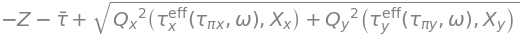

In [29]:
f = norm_Q - Z - bartau
f

Let us now introduce the back stress $X$ by defining the substitution for $Q = \tau^\mathrm{eff} - X$

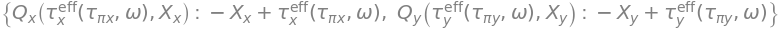

In [30]:
subs_Q = {Q_x: tau_eff_x - X_x, Q_y: tau_eff_y - X_y}
subs_Q

Further substitution rule introduces the effective stress as a function of damage as

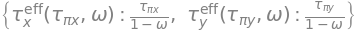

In [31]:
subs_tau_eff = {tau_eff_x: tau_pi_x / (1-omega), tau_eff_y: tau_pi_y / (1-omega)}
subs_tau_eff

After substitutions the yield function reads

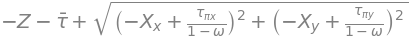

In [32]:
f_ = f.subs(subs_Q).subs(subs_tau_eff)
f_

**Executable code generation** $f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S}})$

Note that this is a function of both the forces and kinematic state variables

In [33]:
get_f = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), f_, 'numpy'
)
get_f_C = ccode('get_f', f_, 'SLIDE1_3')

The derivative of $f$ required for time-stepping $\frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}$ is obtained as

In [34]:
df_dSig_ = f_.diff(Sig)
sp.simplify(df_dSig_).T

⎡                (Xₓ⋅(ω - 1) + τₚᵢ ₓ)⋅│ω - 1│                                 
⎢────────────────────────────────────────────────────────────  ───────────────
⎢            ________________________________________________              ___
⎢       2   ╱                     2                        2          2   ╱   
⎣(ω - 1) ⋅╲╱  (Xₓ⋅(ω - 1) + τₚᵢ ₓ)  + (X_y⋅(ω - 1) + τ_π_y)    (ω - 1) ⋅╲╱  (X

(X_y⋅(ω - 1) + τ_π_y)⋅│ω - 1│                                      (Xₓ⋅(ω - 1)
─────────────────────────────────────────────  -1  ───────────────────────────
_____________________________________________                 ________________
                  2                        2                 ╱                
ₓ⋅(ω - 1) + τₚᵢ ₓ)  + (X_y⋅(ω - 1) + τ_π_y)        (ω - 1)⋅╲╱  (Xₓ⋅(ω - 1) + τ

 + τₚᵢ ₓ)⋅│ω - 1│                                (X_y⋅(ω - 1) + τ_π_y)⋅│ω - 1│
────────────────────────────────  ────────────────────────────────────────────
________________________________             _____

**Executable code generation** $\displaystyle \frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [35]:
get_df_dSig = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), df_dSig_, 'numpy'
)
get_df_dSig_C = ccode('get_df_dSig', df_dSig_, 'SLIDE1_3')

Due to the direct dependency of $f$ on $\boldsymbol{\mathcal{E}}$ also the term $\displaystyle\frac{\partial^\mathrm{dir} f}{\partial^\mathrm{dir} \boldsymbol{\mathcal{E}}}$ must be provided for numerical evaluation of derivatives

In [36]:
ddf_dEps_ = f_.diff(Eps)
ddf_dEps_.T

⎡                     ⎛      τₚᵢ ₓ⎞         ⎛       τ_π_y⎞⎤
⎢               τₚᵢ ₓ⋅⎜-Xₓ + ─────⎟   τ_π_y⋅⎜-X_y + ─────⎟⎥
⎢                     ⎝      1 - ω⎠         ⎝       1 - ω⎠⎥
⎢               ─────────────────── + ────────────────────⎥
⎢                            2                     2      ⎥
⎢                     (1 - ω)               (1 - ω)       ⎥
⎢0  0  0  0  0  ──────────────────────────────────────────⎥
⎢                     __________________________________  ⎥
⎢                    ╱              2                 2   ⎥
⎢                   ╱  ⎛      τₚᵢ ₓ⎞    ⎛       τ_π_y⎞    ⎥
⎢                  ╱   ⎜-Xₓ + ─────⎟  + ⎜-X_y + ─────⎟    ⎥
⎣                ╲╱    ⎝      1 - ω⎠    ⎝       1 - ω⎠    ⎦

**Executable Python code generation** $\displaystyle\frac{\partial }{\partial \boldsymbol{\mathcal{E}}} f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [37]:
get_ddf_dEps = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), ddf_dEps_, 'numpy'
)
get_ddf_dEps_C = ccode('get_df_dEps', ddf_dEps_, 'SLIDE1_3')

## Flow potential
For non-associative flow rule let us define an extension to be added to the threshold function 

In [38]:
phi_ext = S* (1-omega)**c / (r+1) * (Y/S)**(r+1) 

The flow potential $\varphi(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S}})$ reads

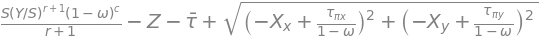

In [39]:
phi_ = f_ + phi_ext
phi_

and the corresponding directions of flow given as a product of the sign operator $\Upsilon$ and of the derivatives with respect to state variables 
$\boldsymbol{\Upsilon} \, \partial_{\boldsymbol{\mathcal{S}}} \varphi$
This renders following flow direction vector
\begin{align}
\boldsymbol{\Phi} = - \Upsilon \frac{\partial \varphi}{\partial \boldsymbol{\mathcal{S}}} 
\end{align}

In [40]:
Phi_ = -Sig_signs * phi_.diff(Sig)
sp.simplify(Phi_.T)

⎡                                                                             
⎢                (Xₓ⋅(ω - 1) + τₚᵢ ₓ)⋅│ω - 1│                                 
⎢────────────────────────────────────────────────────────────  ───────────────
⎢            ________________________________________________              ___
⎢       2   ╱                     2                        2          2   ╱   
⎣(ω - 1) ⋅╲╱  (Xₓ⋅(ω - 1) + τₚᵢ ₓ)  + (X_y⋅(ω - 1) + τ_π_y)    (ω - 1) ⋅╲╱  (X

                                                                              
(X_y⋅(ω - 1) + τ_π_y)⋅│ω - 1│                                    -(Xₓ⋅(ω - 1) 
─────────────────────────────────────────────  1  ────────────────────────────
_____________________________________________                _________________
                  2                        2                ╱                 
ₓ⋅(ω - 1) + τₚᵢ ₓ)  + (X_y⋅(ω - 1) + τ_π_y)       (ω - 1)⋅╲╱  (Xₓ⋅(ω - 1) + τₚ

                                                  

**Executable code generation** $\boldsymbol{\Phi}(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [41]:
get_Phi = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), Phi_, 'numpy'
)
get_Phi_C = ccode('get_Phi', Phi_, 'SLIDE1_3')

# Time integration scheme

## Discrete yield condition
In a continuous case we consistency condition to explicitly glue the state onto the yield surface 
\begin{align}
\dot{f}(\boldsymbol{\mathcal{S}}(s, \boldsymbol{\mathcal{E}(\lambda)}), \boldsymbol{\mathcal{E}(\lambda)} ) &= 0 \end{align}
In discrete case, we relax this requirement. Indeed, by taking $f(s_{n+1}; \boldsymbol{\mathcal{E}_n}) $ as a first trial value we can obtain positive values.

&nbsp;<font color="green">
**We allow for "trial" states which lie beyond the admissible domain $f \le 0$ during iteration. This allows us to construct a "return mapping" algorithm that iteratively approaches an admissible state on the yield surface.**</font>

Given an inadmissible trial state $k$ with the yield condition $f_k > 0$, let us introduce a linearized approximation of its change along the plastic multiplier $\lambda$ around the state $k$. 
\begin{align}
 f_{k+1} &= f_{k} + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda
\end{align}
In this form, we can search for an admissible state $f_{n+1} = 0$ by iterating over $k$.
Note that in initial iteration $k = 0$ the state from previous step is reused, i.e. 
$f(s_{n+1}; \boldsymbol{\mathcal{E}_n}) $.

In the linearized form, we can transform the yield condition to a recurrent formula
\begin{align}
\left. \frac{\mathrm{d} f}{\mathrm{d} \lambda}\right|_k \Delta \lambda &= -f_k,
\hspace{1cm} f_k \rightarrow 0 \; \;\mathrm{for}\;\; k = 1\ldots\infty
\end{align}
This resembles the Newton method for iterative solution of a nonlinear equation. However, we need to consider the fact that the level of inadmissibility $f$ changes between iterations. 
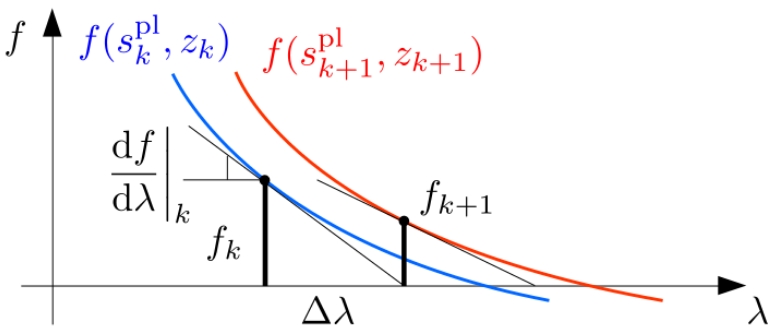
Note that the predictor is negative and $\Delta \lambda > 0$. In every step, the plastic multiplier is updated:
\begin{align}
\lambda_{k+1} &= \lambda_k + \Delta \lambda, \, \lambda_0 = 0 \nonumber \\ \nonumber
\end{align}

Two more questions must addressed to define a general numerical algorithm for plasticity:
<font color="brown">
 * **Update of state variables $\boldsymbol{\mathcal{E}}_{k+1}$ in each iteration**
 * **Expression of the predictor $\mathrm{d} f / \mathrm{d} \lambda$ in terms of the state variables**
</font>

## State update
In every iteration step the state variables $\boldsymbol{\mathcal{E}}$ must be updated using the discrete evolution equations, i.e. 
\begin{align}
\boldsymbol{\mathcal{E}}_{k+1} &= 
\boldsymbol{\mathcal{E}}_k + \lambda_{k+1} 
\boldsymbol{\Phi}_k
\label{eq:discrete_evolution}
\end{align}
Which is used in the calculation of the threshold function in the next step. Note that $\boldsymbol{\Phi}_k$ is evaluated in the state $k$ and not $k+1$.

To reach an admissible state let us linearize the threshold function at an interim state $k$ as
\begin{align}
f_{k+1} = 
f_k 
 +
\left.
\frac
{\partial f}
{\partial \lambda}
\right|_k
\Delta \lambda
\end{align}

## Predictor
\begin{align}
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
&=
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k =
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\boldsymbol{\Phi}_k \\
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
&=
\left. \frac{\partial f}{ \partial \boldsymbol{\mathcal{S}}}\right|_{k}
\left. \frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}\right|_{k}
+
\left. \frac{\partial^{\mathrm{dir}} f}{ \partial^{\mathrm{dir}} \boldsymbol{\mathcal{E}}}\right|_{k}
\label{eq:df_dlambda}
\end{align}

**Remark 1:** The derivative $\partial^\mathrm{dir}$ denotes the direct derivative with respect to $\boldsymbol{\mathcal{E}}$

**Remark 2:** Note that $\displaystyle \frac{\partial \boldsymbol{\mathcal{E}}}{\partial \lambda}$ in equation $\eqref{eq:df_dlambda}$ can be obtained from the evolution equations $\eqref{eq:discrete_evolution}$
\begin{align}
\boldsymbol{\mathcal{E}}_k = \boldsymbol{\mathcal{E}}_n + \lambda \, \boldsymbol{\Phi}_k\; \implies
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k = 
\boldsymbol{\Phi}_k
\end{align}

Thus, by rewriting the linearized equation as a recurrence formula, the iteration algorithm is obtained
\begin{align}
&
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
\Delta \lambda
= - f^{(k)}\\
& \lambda_{k+1} = \lambda_{k} + \Delta \lambda \\
& \boldsymbol{\mathcal{E}}_{k+1} = \boldsymbol{\mathcal{E}}_{k} + 
 \lambda_{k} \, 
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
 \\
&k = k + 1
\end{align}

## Implementation concept
The gradient operators needed for the time-stepping scheme have been derived above and are now available for the implementation of the numerical algorithm both in `Python` and `C89` languages

<table style="width:50%">
<tr>
<th>Symbol</th>
<th>Python</th>
<th>C89</th>
</tr>
<tr>
<td>$\mathcal{S}(s, \boldsymbol{\mathcal{E}}) $  
</td>
<td>get_Sig</td>
<td>get_Sig_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{E}}  \boldsymbol{\mathcal{S}}(s, \boldsymbol{\mathcal{E}}) $</td>
<td>get_dSig_dEps</td>
<td>get_dSig_dEps_C</td>
</tr>
<tr>
<td>$ f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}})$</td>
<td>get_f</td>
<td>get_f_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{S}} f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $  
</td>
<td>get_df_dSig</td>
<td>get_df_dSig_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{E}} f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_df_dEps</td>
<td>get_df_dEps_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{S}} \varphi(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_Phi</td>
<td>get_Phi_C</td>
</tr>
</table>

**Threshold and its derivatives:** To avoid repeated calculation of the same expressions, let us put the evaluation of $f$ and $\partial_\lambda f$ into a single procedure. The iteration loop can be constructed in such a way that the predictor for the next step is calculated along with the residuum. In case that the residuum is below the required tolerance, the overhead for an extra calculated derivative is negligible or, with some care, can be even reused in the next time step.  

In [45]:
def get_f_df(s_x_n1, s_y_n1, Eps_k, **kw):
    Sig_k = get_Sig(s_x_n1, s_y_n1, Eps_k, **kw)[0]
    dSig_dEps_k = get_dSig_dEps(s_x_n1, s_y_n1, Eps_k, **kw)
    f_k = np.array([get_f(Eps_k, Sig_k, **kw)])
    df_dSig_k = get_df_dSig(Eps_k, Sig_k, **kw)
    ddf_dEps_k = get_ddf_dEps(Eps_k, Sig_k, **kw)
    df_dEps_k = np.einsum(
        'ik,ji->jk', df_dSig_k, dSig_dEps_k) + ddf_dEps_k
    Phi_k = get_Phi(Eps_k, Sig_k, **kw)
    dEps_dlambda_k = Phi_k
    df_dlambda = np.einsum(
        'ki,kj->ij', df_dEps_k, dEps_dlambda_k)
    df_k = df_dlambda
    return f_k, df_k, Sig_k

**Evolution equations:** The update of state variables for an updated $\lambda_k$ is performed using this procedure.

In [46]:
def get_Eps_k1(s_x_n1, s_y_n1, Eps_n, lam_k, Eps_k, **kw):
    Sig_k = get_Sig(s_x_n1, s_y_n1, Eps_k, **kw)[0]
    Phi_k = get_Phi(Eps_k, Sig_k, **kw)
    Eps_k1 = Eps_n + lam_k * Phi_k[:,0]
    return Eps_k1

**Return mapping iteration:** This function represents a user subroutine in a finite element code or in a lattice model. The input is $s_{n+1}$ and the state variables representing the state in the previous solved step $\boldymbol{\mathcal{E}}_n$. The procedure returns the stresses and state variables of $\boldsymbol{\mathcal{S}}_{n+1}$ and $\boldsymbol{\mathcal{E}}_{n+1}$

In [47]:
def get_material_model(s_x_n1, s_y_n1, Eps_n, k_max, **kw):
    Eps_k = np.copy(Eps_n)
    lam_k = 0
    f_k, df_k, Sig_k = get_f_df(s_x_n1, s_y_n1, Eps_k, **kw)
    f_k_norm = np.linalg.norm(f_k)
    f_k_trial = f_k[0]
    k = 0
    while k < k_max:
        if f_k_trial < 0 or f_k_norm < 1e-6:
            return Eps_k, Sig_k, k+1
        dlam = np.linalg.solve(df_k, -f_k)
        lam_k += dlam
        Eps_k = get_Eps_k1(s_x_n1, s_y_n1, Eps_n, lam_k, Eps_k, **kw)
        f_k, df_k, Sig_k = get_f_df(s_x_n1, s_y_n1, Eps_k, **kw)
        f_k_norm = np.linalg.norm(f_k)
        k += 1
    else:
        raise ValueError('no convergence')

**Loop over the time increments** for a single material point. This loop emulates the  finite-element spatial integration or a lattice-assembly algorithm.  

In [48]:
def get_response(s_max=[3,0], n_steps = 10, k_max=20, get_load_fn=lambda t: t, **kw):
    Eps_n1 = np.zeros((len(Eps),), dtype=np.float_)
    Sig_record = []
    Eps_record = []
    iter_record = []
    t_arr = np.linspace(0,1,n_steps+1)
    s_x_max, s_y_max = s_max 
    s_x_t = s_x_max * get_load_fn(t_arr) + 1e-9
    s_y_t = s_y_max * get_load_fn(t_arr) + 1e-9
    for s_x_n1, s_y_n1 in zip(s_x_t, s_y_t):
        Eps_n1, Sig_n1, k = get_material_model(s_x_n1, s_y_n1, Eps_n1, k_max, **kw)
        Sig_record.append(Sig_n1)
        Eps_record.append(Eps_n1)
        iter_record.append(k+1)
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    return t_arr, s_x_t, s_y_t, Eps_arr, Sig_arr, iter_arr

In [49]:
material_params = dict(
    E_b=1, gamma= 0.1, K=0.2, S=0.6, r=0.001, c=1, bartau=1, 
)

In [50]:
t_arr, s_x_t, s_y_t, Eps_arr, Sigma_arr, iter_arr = get_response(
    s_max=[1.1,0], n_steps=1, k_max=5, **material_params
)

# Support functions
To run some examples, let us define some infrastructure including a more complex loading history and postprocessing

## Loading history
This implementation uses the symbolic machinery which is not necessary a simpler data point based implementation with `numpy.interp1d` would be better ... later 

<IPython.core.display.Javascript object>


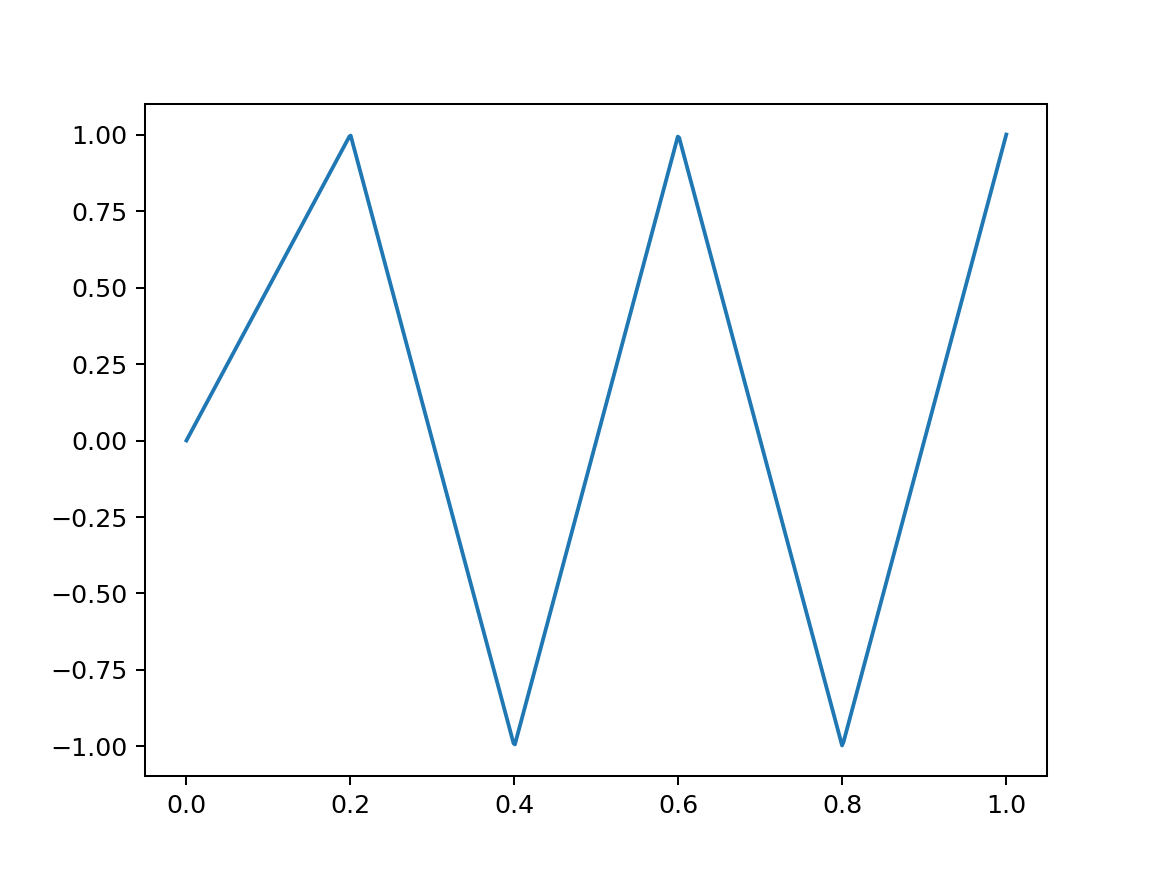

In [51]:
t, theta = sp.symbols(r't, \theta')
n_cycles = 5
A = 2
ups = np.array([((theta-2*cycle)*A+(1-A), theta-2*cycle<=1) 
                for cycle in range(n_cycles)])
downs = np.array([((1-(theta-(2*cycle+1)))*A+(1-A),(theta-(2*cycle+1))<=1) 
                  for cycle in range(n_cycles)])
ups[0,0] = theta
updowns = np.einsum('ijk->jik',np.array([ups, downs])).reshape(-1,2)
load_fn = sp.Piecewise(*updowns).subs(theta,t*n_cycles)
get_load_fn = sp.lambdify(t, load_fn,'numpy')
t_arr = np.linspace(0,1,600)
plt.plot(t_arr, get_load_fn(t_arr));

## Plotting functions
To simplify postprocessing examples, here are two aggregate plotting functions, one for the state and force variables, the other one for the evaluation of energies

In [52]:
def plot_Sig_Eps(s_x_t, Sig_arr, Eps_arr, iter_arr, 
                 ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44):
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    s_x_pi_, s_y_pi_, z_, alpha_x_, alpha_y_, omega_ = Eps_arr.T
    tau_x_pi_, tau_y_pi_, Z_, X_x_, X_x_, Y_ = Sig_arr.T
    n_step = len(s_x_pi_)
    ax1.plot(s_x_t, tau_x_pi_, color='black', 
             label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
    ax1.legend()
    ax11.plot(s_x_t, iter_arr, '-.')
    ax2.plot(t_arr, omega_, color='red', 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
    ax22.plot(t_arr, Y_, '-.', color='red', 
             label='n_steps = %g' % n_step)
    ax22.set_ylabel('$Y$')
    ax3.plot(t_arr, z_, color='green', 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$z$')
    ax33.plot(t_arr, Z_, '-.', color='green')
    ax33.set_ylabel(r'$Z$')
    ax4.plot(t_arr, alpha_x_, color='blue', 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$Z$')
    ax44.plot(t_arr, X_x_, '-.', color='blue')

In [53]:
from scipy.integrate import cumtrapz
def plot_work(ax, t_arr, s_x_t, s_y_t, Eps_arr, Sig_arr):
    W_arr = cumtrapz(Sig_arr[:,0], s_x_t, initial=0) + cumtrapz(Sig_arr[:,1], s_y_t, initial=0)
    U_arr = Sig_arr[:,0] * (s_x_t-Eps_arr[:,0]) / 2.0 + Sig_arr[:,1] * (s_y_t-Eps_arr[:,1]) / 2.0
    G_arr = W_arr - U_arr
    ax.plot(t_arr, W_arr, lw=2, color='black', label=r'$W$')
    ax.plot(t_arr, G_arr, color='black', label=r'$G$')
    ax.fill_between(t_arr, W_arr, G_arr, color='green', alpha=0.2)
    ax.set_xlabel('$s$'); ax3.set_ylabel(r'$E$')
    ax.legend()

In [54]:
def plot_dissipation(ax, t_arr, Eps_arr, Sig_arr):    
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    E_i = cumtrapz(Sig_arr, Eps_arr, initial=0, axis=0)
    c = 'black'
    ax.plot(t_arr, E_i[:,0]+E_i[:,1], '-.', lw=1, color=c)
    ax.fill_between(t_arr, E_i[:,0]+E_i[:,1], 0, color=c, alpha=0.1)
    c = 'black'
    ax.plot(t_arr, E_i[:,0]+E_i[:,1] + E_i[:,-1]+E_i[:,-2], color=c, lw=1)
    ax.fill_between(t_arr, E_i[:,0]+E_i[:,1] + E_i[:,-1]+E_i[:,-2], 
                    E_i[:,0]+E_i[:,1], 
                    color=c, alpha=0.2);
    c = 'blue'
    ax.plot(t_arr, E_i[:,2], '-.', lw=1, color='black')
    ax.fill_between(t_arr, E_i[:,2], 0, color=c, alpha=0.1)
    c = 'blue'
    ax.plot(t_arr, E_i[:,2] + E_i[:,3], color='black', lw=1)
    ax.fill_between(t_arr, E_i[:,2] + E_i[:,3], E_i[:,2], 
                    color=c, alpha=0.3);

# Examples

## Monotonic load 
Let's first run the example with different size of the time step to see if there is any difference

<IPython.core.display.Javascript object>


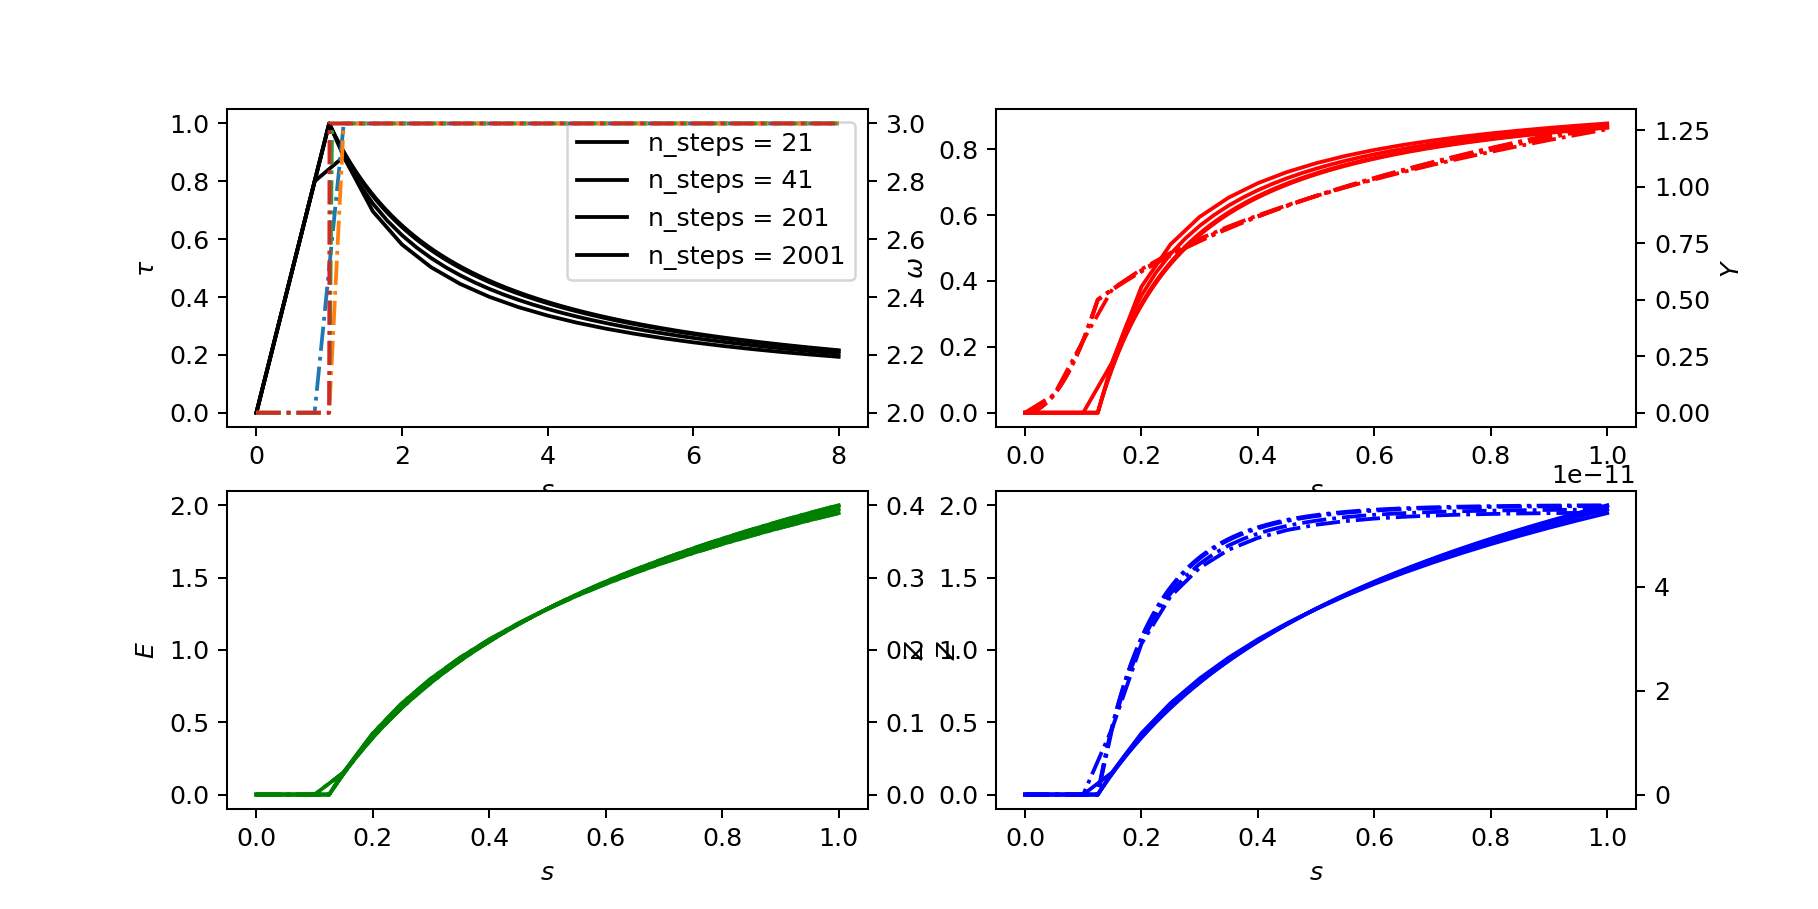

In [55]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,5))
ax11 = ax1.twinx()
ax22 = ax2.twinx()
ax33 = ax3.twinx()
ax44 = ax4.twinx()
axes = ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44
for n_steps in [20, 40, 200, 2000]:
    t_arr, s_x_t, s_y_t, Eps_arr, Sig_arr, iter_arr = get_response(
        s_max=[8,0], n_steps=n_steps, k_max=10, **material_params
    )
    plot_Sig_Eps(s_x_t, Sig_arr, Eps_arr, iter_arr, *axes)

<IPython.core.display.Javascript object>


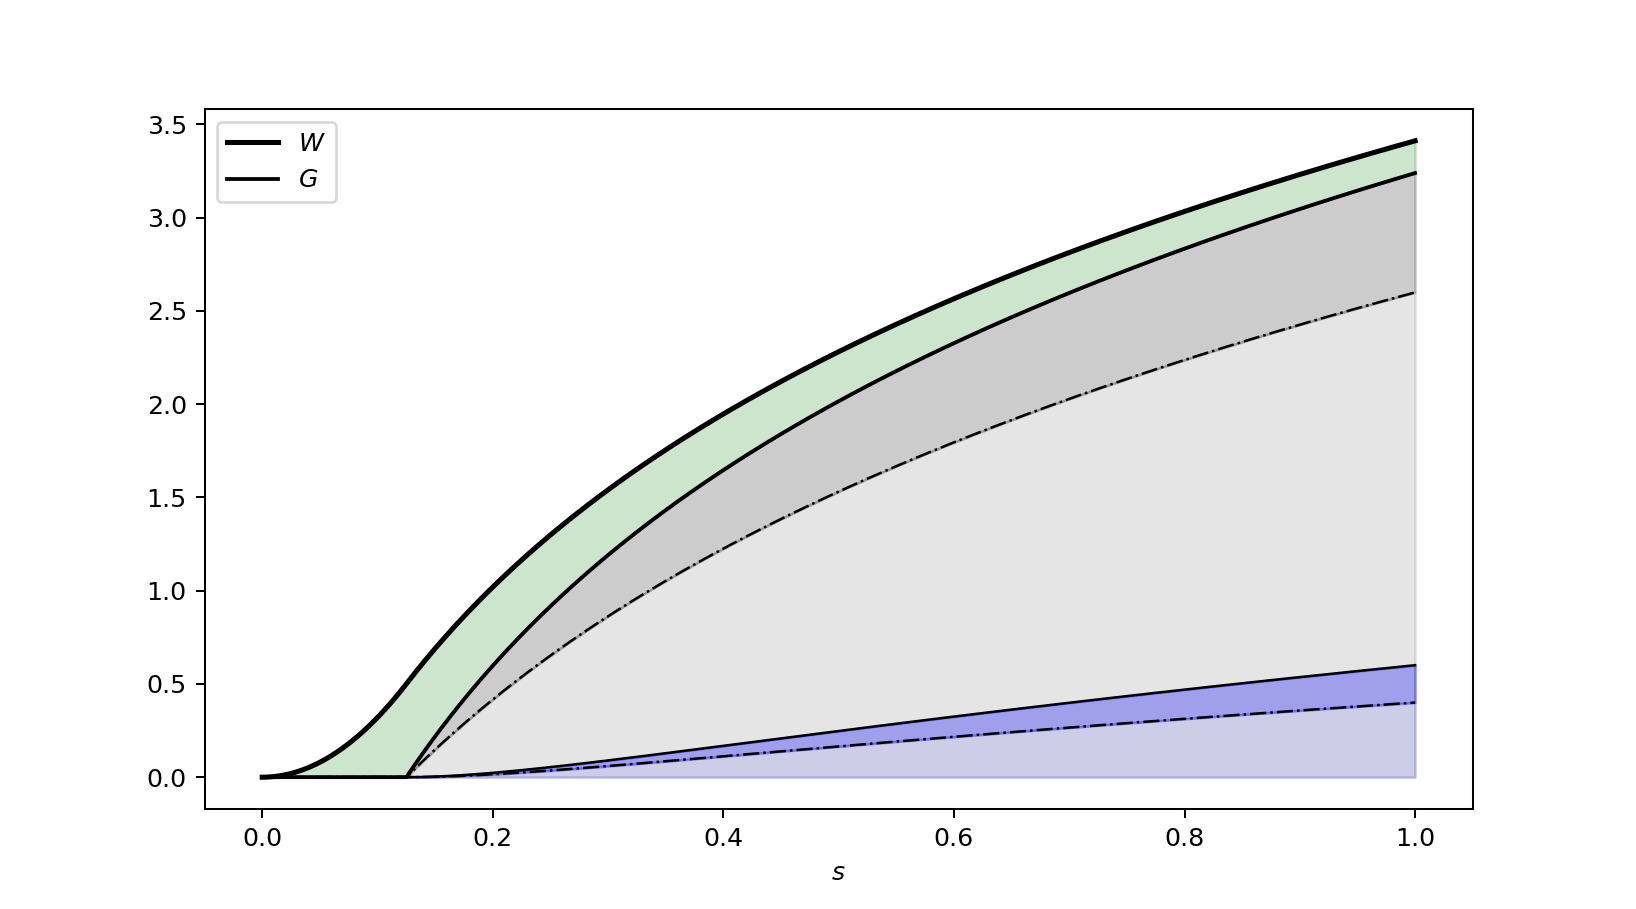

In [56]:
fig, ax = plt.subplots(1,1,figsize=(9, 5))
plot_work(ax, t_arr, s_x_t, s_y_t, Eps_arr, Sig_arr)
plot_dissipation(ax, t_arr, Eps_arr, Sig_arr)

## Cyclic loading

<IPython.core.display.Javascript object>


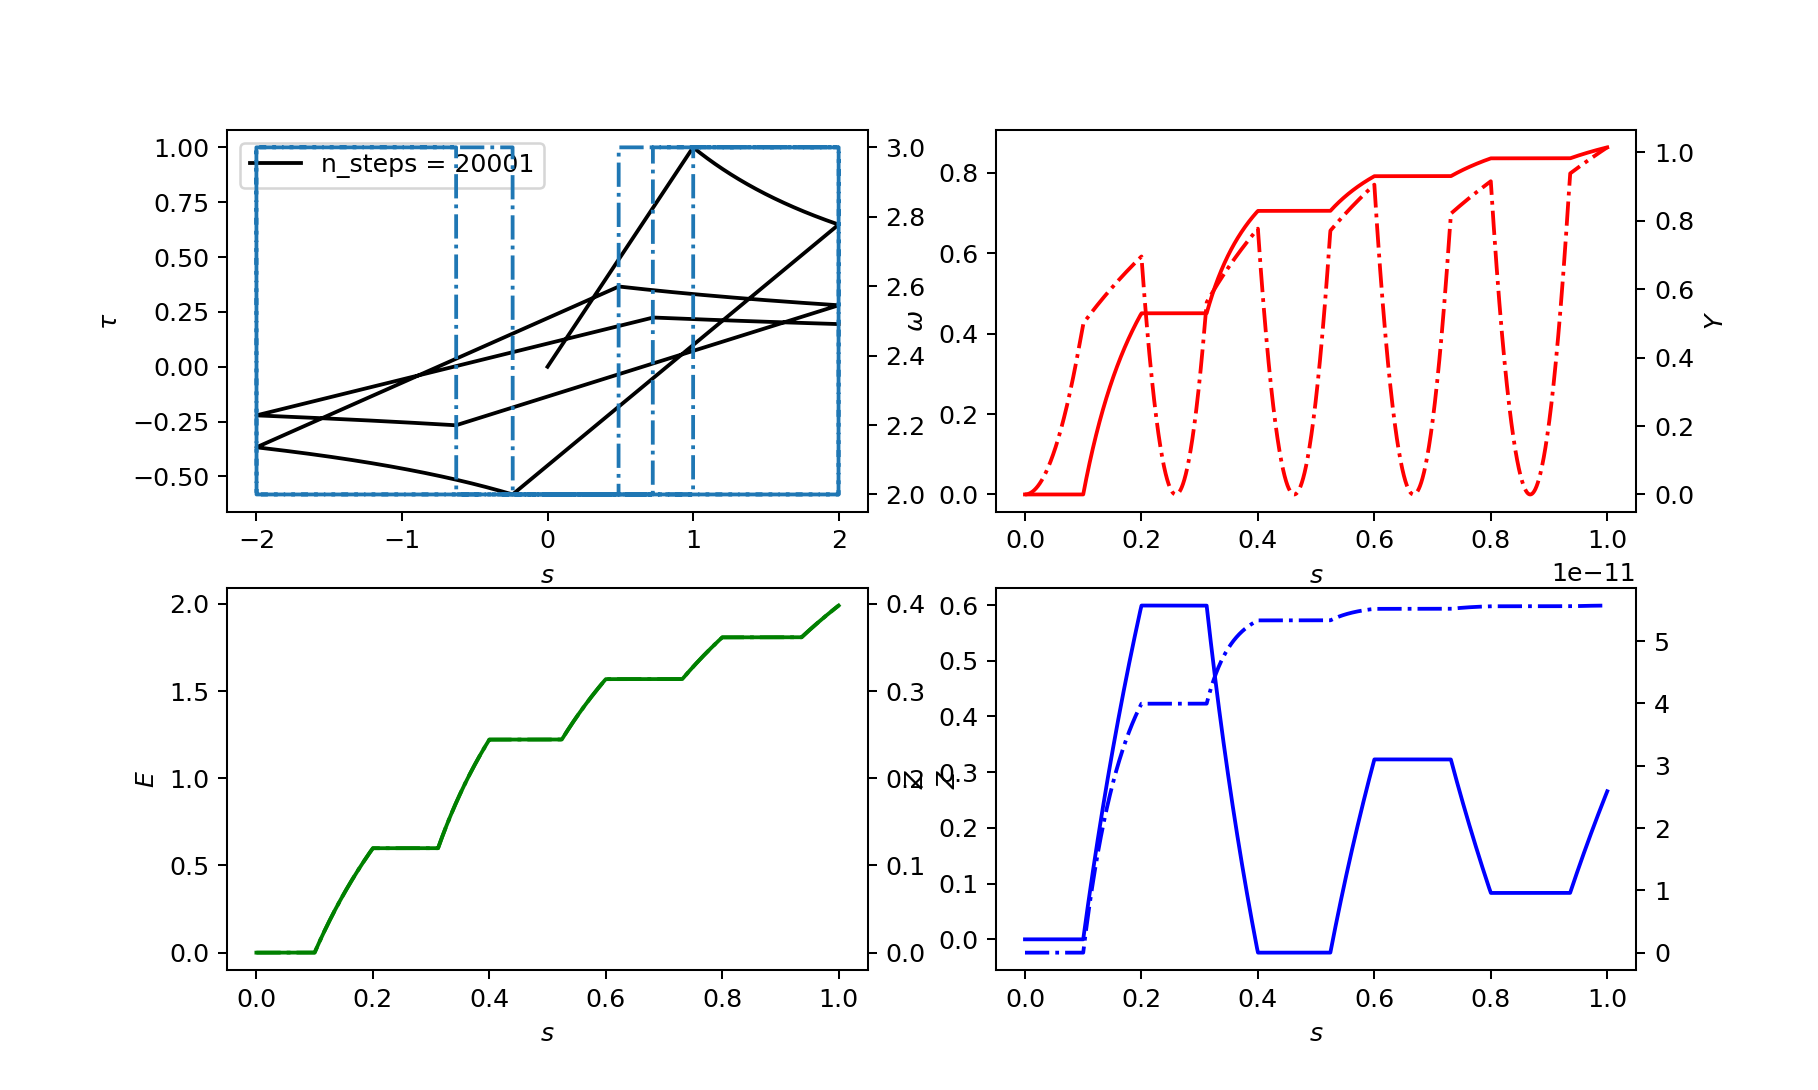

In [57]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax11 = ax1.twinx()
ax22 = ax2.twinx()
ax33 = ax3.twinx()
ax44 = ax4.twinx()
axes = ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44
t_arr, s_x_t, s_y_t, Eps_arr, Sig_arr, iter_arr = get_response(
    s_max=[2,0], n_steps=20000, k_max=20, get_load_fn=get_load_fn, **material_params
)
plot_Sig_Eps(s_x_t, Sig_arr, Eps_arr, iter_arr, ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44)

<IPython.core.display.Javascript object>


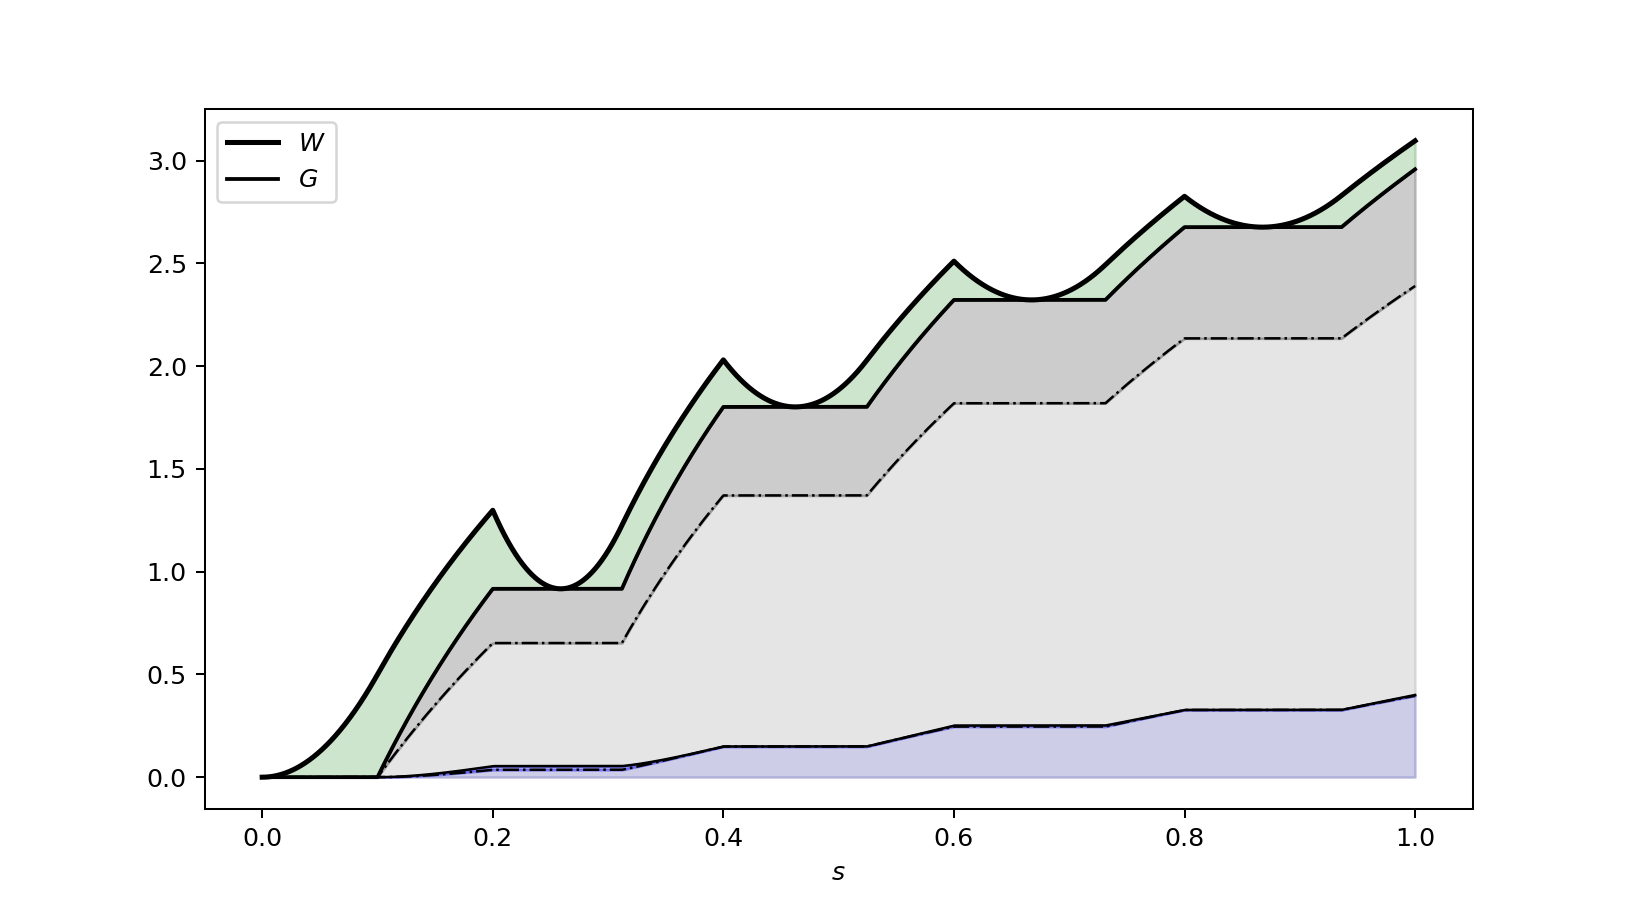

In [58]:
fig, ax = plt.subplots(1,1,figsize=(9, 5))
plot_work(ax, t_arr, s_x_t, s_y_t, Eps_arr, Sig_arr)
plot_dissipation(ax, t_arr, Eps_arr, Sig_arr)

# Interactive application

In [59]:
def get_tau_s(s_x_n1, s_y_n1, Eps_n, **kw):
    '''Get the stress for the slip in x, y dirctions given the state kappa_n'''
    _, _, kappa_n = Eps_n
    s_equiv = get_s_equiv(s_x_n1, s_y_n1)
    # adapt the shape of the state array 
    kappa_n_ = np.broadcast_to(kappa_n, s_equiv.shape)
    kappa_n1 = np.max(np.array([kappa_n_, s_equiv], dtype=np.float_),axis=0)
    E_b = kw['E_b']
    omega_n1 = 1 - get_g(kappa_n1, **kw)
    tau_x_n1 = (1 - omega_n1) * E_b * s_x_n1
    tau_y_n1 = (1 - omega_n1) * E_b * s_y_n1
    return (
        np.array([s_x_n1, s_y_n1, kappa_n1]),
        np.array([tau_x_n1, tau_y_n1, omega_n1])
    )

def plot_tau_s(ax, Eps_n, s_max, n_s, get_g, **kw):
    n_s_i = complex(0,n_s)
    s_x_n1, s_y_n1 = np.mgrid[-s_max:s_max:n_s_i, -s_max:s_max:n_s_i]
    Eps_n1, Sig_n1 = get_tau_s(s_x_n1, s_y_n1, Eps_n, get_g, **kw)
    s_x_n1, s_y_n1, _ = Eps_n1
    tau_x_n1, tau_y_n1, _ = Sig_n1
    tau_n1 = np.sqrt(tau_x_n1**2 + tau_y_n1**2)
    ax.plot_surface(s_x_n1, s_y_n1, tau_n1, alpha=0.2)
    phi=np.linspace(0,2*np.pi,100)
    _, _, kappa_n = Eps_n
    s_0 = kw['s_0']
    E_b = kw['E_b']
    r = max(s_0, kappa_n)
    omega_n = 1-get_g(r,**kw)
    f_t = (1-omega_n)*E_b*r
    s0_x, s0_y = r*np.sin(phi), r*np.cos(phi)
    ax.plot(s0_x, s0_y, 0, color='gray')
    ax.plot(s0_x, s0_y, f_t, color='gray')
    ax.set_xlabel(r'$s_x$ [mm]');ax.set_ylabel(r'$s_y$ [mm]');
    ax.set_zlabel(r'$\| \tau \| = \sqrt{\tau_x^2 + \tau_y^2}$ [MPa]');

<IPython.core.display.Javascript object>


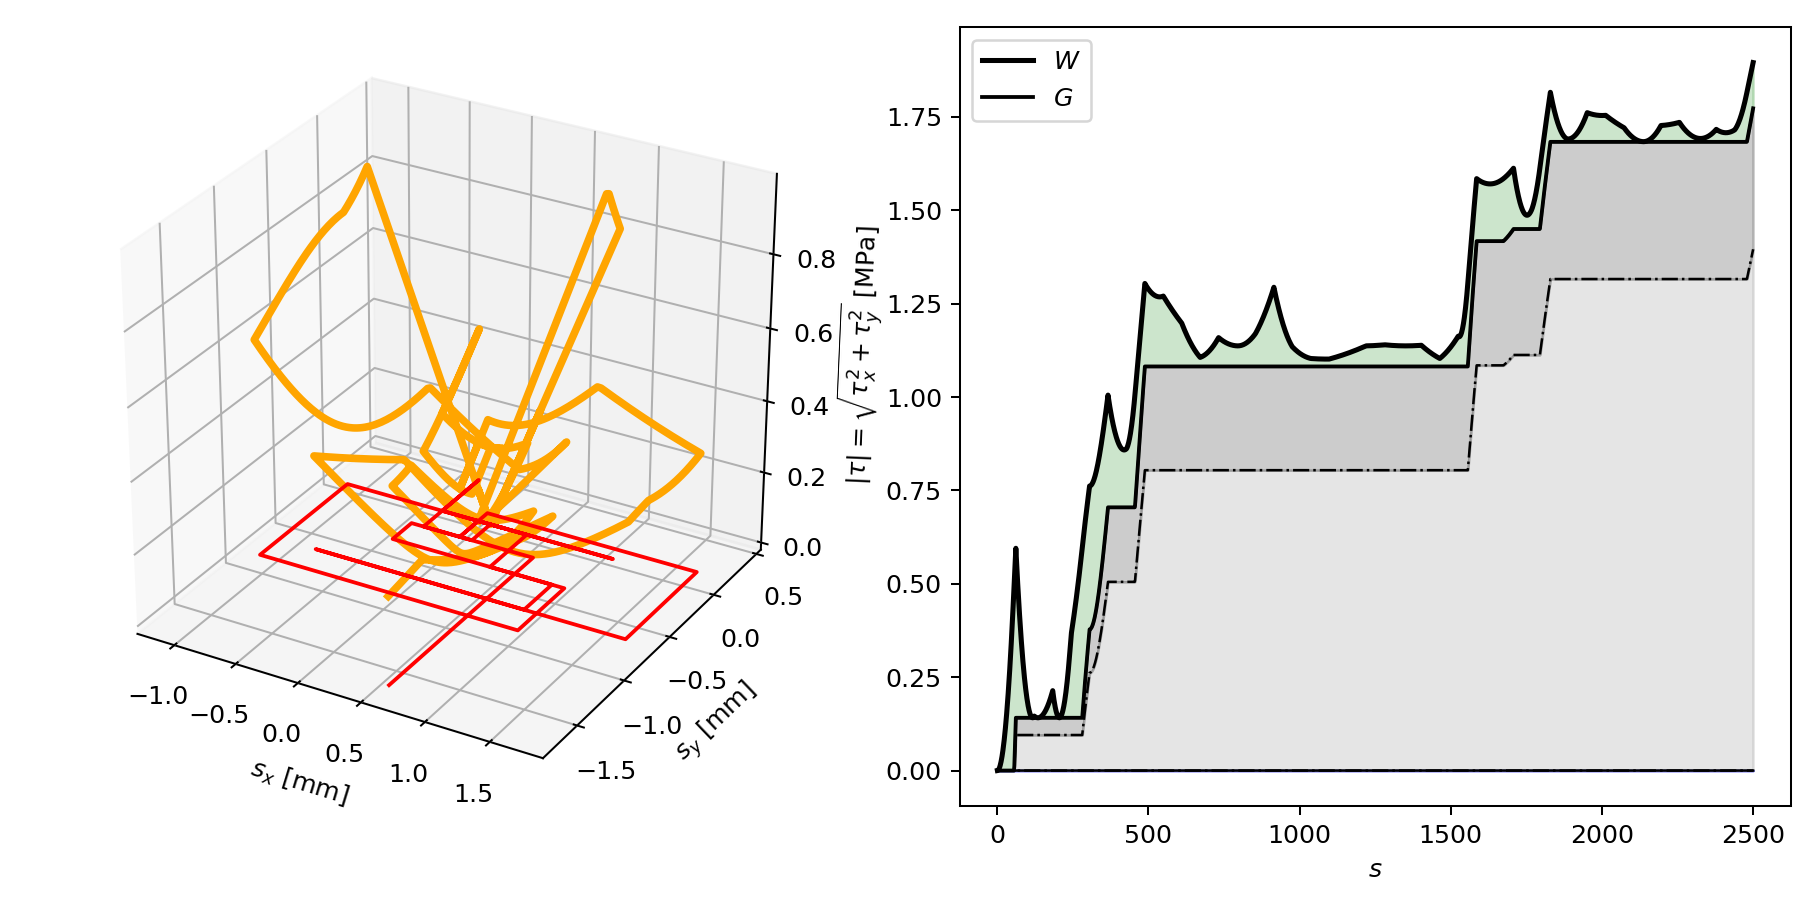

In [60]:
def init():
    global Eps_record, Sig_record, iter_record
    global t_arr, s_x_t, s_y_t, s_x_0, s_y_0, t0, Eps_n1
    s_x_0, s_y_0 = 0, 0
    t0 = 0
    Sig_record = []
    Eps_record = []
    iter_record = []
    t_arr = []
    s_x_t, s_y_t = [], []
    Eps_n1 = np.zeros((len(Eps),), dtype=np.float_)

def get_response_i(s_x_1, s_y_1, n_steps = 60, k_max=20, **kw):
    global Eps_record, Sig_record, iter_record
    global t_arr, s_x_t, s_y_t, s_x_0, s_y_0, t0, Eps_n1
    t1 = t0+n_steps+1
    ti_arr = np.linspace(t0, t1, n_steps+1 )
    si_x_t = np.linspace(s_x_0,s_x_1,n_steps+1)
    si_y_t = np.linspace(s_y_0,s_y_1,n_steps+1)
    for s_x_n1, s_y_n1 in zip(si_x_t, si_y_t):
        Eps_n1, Sig_n1, k = get_material_model(s_x_n1, s_y_n1, Eps_n1, k_max, **kw)
        Sig_record.append(Sig_n1)
        Eps_record.append(Eps_n1)
        iter_record.append(k+1)
    t_arr = np.hstack([t_arr, ti_arr])
    s_x_t = np.hstack([s_x_t, si_x_t])
    s_y_t = np.hstack([s_y_t, si_y_t])
    t0 = t1
    s_x_0, s_y_0 = s_x_1, s_y_1
    return

import ipywidgets as ipw

def plot3d_Sig_Eps(ax3d, s_x_t, s_y_t, Sig_arr, Eps_arr):
    tau_x, tau_y = Sig_arr.T[:2,...]
    tau = np.sqrt( tau_x**2 + tau_y**2 )
    ax3d.plot3D(s_x_t, s_y_t, tau, color='orange', lw=3)

fig = plt.figure(figsize=(10,5), tight_layout=True)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)
def update(s_x_1, s_y_1):
    global Eps_record, Sig_record, iter_record
    global t_arr, s_x_t, s_y_t, s_x_0, s_y_0, t0, Eps_n
    global kwargs
    get_response_i(s_x_1, s_y_1, **kwargs)
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    ax1.clear()
    ax2.clear()
#    plot_tau_s(ax1, Eps_arr[-1,...],s_max,500,get_g3,**kw)
    plot3d_Sig_Eps(ax1, s_x_t, s_y_t, Sig_arr, Eps_arr)
    ax1.plot(s_x_t, s_y_t, 0, color='red')
    ax1.set_xlabel(r'$s_x$ [mm]');ax1.set_ylabel(r'$s_y$ [mm]');
    ax1.set_zlabel(r'$\| \tau \| = \sqrt{\tau_x^2 + \tau_y^2}$ [MPa]');
    
    plot_work(ax2, t_arr, s_x_t, s_y_t, Eps_arr, Sig_arr)
    plot_dissipation(ax2, t_arr, Eps_arr, Sig_arr)
    
s_x_1_slider = ipw.FloatSlider(value=0,min=-4, max=+4, step=0.1,
                               continuous_update=False)
s_y_1_slider = ipw.FloatSlider(value=0,min=-4, max=+4, step=0.1,
                               continuous_update=False)

def reset(**kwargs_):
    global kwargs
    kwargs = kwargs_
    init()
    s_x_1_slider.value = 0
    s_y_1_slider.value = 0

n_steps = 20
kwargs = dict(
   E_b=1, gamma=0.0, K=0, S=0.6, r=0.001, c=1, bartau=1, 
)
kwargs_sliders = {
    name : ipw.FloatSlider(description=name, value=val, 
                            min=minval, max=maxval, step=(maxval-minval) / n_steps,
                           continuous_update=False)
    for name, val, minval, maxval in [('E_b', 1, 0.5, 100),
                                      ('S', 0.6, 0.00001, 100),
                                      ('r', 0.001, 0.0001, 10),
                                      ('c', 1, 0.0001, 10),
                                      ('gamma', 0, -20, 20),
                                      ('K', 0, -20, 20),
                                      ('bartau', 1, 0.5, 20)]
}
slip_sliders = {'s_x_1': s_x_1_slider, 's_y_1': s_y_1_slider}

def slider_layout(out1, out2):
    layout = ipw.Layout(grid_template_columns='1fr 1fr')
    slider_list = tuple(kwargs_sliders.values())
    grid = ipw.GridBox(slider_list, layout=layout)
    slip_slider_list = tuple(slip_sliders.values())
    hbox = ipw.HBox(slip_slider_list)
    box = ipw.VBox([hbox, grid, out1, out2])
    display(box)
    
init()
out1 = ipw.interactive_output(update, slip_sliders)
out2 = ipw.interactive_output(reset, kwargs_sliders);
slider_layout(out1, out2)

# Code generation
See the docs for the code generation, the latexified  sympy symbols 
must be substituted such that they can act as standard C variable names.
The issue with this substitution might have been partially fixed by the substitution
code defined by this code.

The methods 
 * `get_f_df()`, and 
 * `get_Eps_n1` must be rewritten in C.
 
**How to transform `einsum` to C?**

The state arrays `Eps` and `Sig` must be prepared by the callee, i.e. the function to be 
called from at a level of material point in a finite-element or lattice code.
All the state variable matrices are flattened in the generated C code so that index access operators must be constructed with the correct convention, i.e. 
`i * n_row + j` or `i + n_col * j`. 

Let us consider the line
```Python
df_dEps_k = np.einsum('ik,ji->jk', df_dSig_k, dSig_dEps_k) + ddf_dEps_k
````

To transform this systematically into the C loop it is proposed define
index directives specifying the size of the first dimension. Then, the 
indexes from the `einsum` call can be systematically transferred to the 
multi-loop running over the indexes and respecting their order. No more 
thinking needed. The index operators below are prepared for arrays with 
2, 3, and 4 dimensions.
```C
#define IJ(N_I,I,J) (N_I * J + I)
#define IJK(N_I,N_J,I,J,K) (N_I * IJ(N_J,J,K) + I)
#define IJKL(N_I,N_J,N_K,I,J,K,L) (N_I * IJK(N_J,N_K,J,K,L) + I)
````
to perform the matrix multiplication
```C
int k=0;
for(int i=0;i<N_I;i++)
    for(int j=0;j<N_J;j++)
        df_dEps_1[IJ(N_J,j,k)] += df_dSig_k[IJ(N_I(i,k)] * dSig_dEps_k[IJ(N_J,j,i)]
    df_dEps[IJ(N_I,i,k)] = df_dEps_1[IJ(N_J,j,k)] + ddSig_dEps(IJ(N_I,i,k)];
````

The whole material model is represented by the material method
that mimics the internal par of the `get_response` function defined above

 1. Call `get_f_df()` to get the trial state
 2. Start the return mapping iteration loop
 3. If admissibility criterion fulfilled - admissible state found - return stress
 4. Evaluate delta of plastic multiplier and update it
 5. Update state variables using evolution equations `get_Eps_n1`
 6. Evaluate the residuum using `get_f_df()` and continuum with point 3.
 

In [ ]:
C_code = get_Sig_C, get_dSig_dEps_C, get_f_C, get_df_dSig_C, get_ddf_dEps_C, get_Phi_C 

In [ ]:
import os
import os.path as osp

code_dirname = 'sympy_codegen'
code_fname = 'SLIDE_1_3_2D'

home_dir = osp.expanduser('~')
code_dir = osp.join(home_dir, code_dirname)
if not osp.exists(code_dir):
    os.makedirs(code_dir)

code_file = osp.join(code_dir, code_fname)

print('code_file', code_file)
h_file = code_file + '.h'
c_file = code_file + '.c'

h_f = open(h_file,'w') 
c_f = open(c_file,'w')

if True:
    for function_C in C_code:
        h_f.write(function_C[1][1])
        c_f.write(function_C[0][1])
h_f.close()
c_f.close()